# Customer Churn Prediction System using Machine Learning

## Project Overview

This project implements an **end-to-end Customer Churn Prediction System** using Machine Learning to identify customers who are likely to leave a bank. The solution focuses on **feature engineering, class imbalance handling, and production-ready pipelines** to support real-world deployment.

---

## Dataset

* **Source:** <a href = 'https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction'>https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction</a>
* Contains customer demographic, financial, and behavioral information.
* Target variable: **`Exited`** (1 = churned, 0 = retained)
* Dataset exhibits **class imbalance**, requiring specialized handling.

---

## Feature Engineering

Feature engineering is centralized in a reusable function to ensure **consistency between training and prediction**.

### Engineered Features

* **Balance–Salary Ratio**
  Captures financial stress relative to income.
* **Tenure-by-Age Ratio**
  Represents customer loyalty normalized by age.
* **CreditScore–Age Ratio**
  Normalizes creditworthiness across age groups.

### Dropped Columns

* Identifiers with no predictive value:

  * `RowNumber`
  * `CustomerId`
  * `Surname`

---

## Machine Learning Pipeline

A fully automated **Imbalanced-Learn Pipeline** is used to prevent data leakage and simplify training and inference.

### Data Preprocessing

* **Numerical Features**

  * Standardized using `StandardScaler`
* **Categorical Features**

  * One-hot encoded using `OneHotEncoder`
  * Robust to unseen categories during inference

### Class Imbalance Handling

* **SMOTE (Synthetic Minority Over-sampling Technique)**

  * Generates synthetic churn samples
  * Sampling strategy set to **30%** to balance recall and precision

### Model

* **Gradient Boosting Classifier**

  * 150 estimators
  * Learning rate: 0.1
  * Tree depth: 4
* Chosen for strong performance on structured/tabular data

---

## Model Training

* Data split using **stratified sampling** to preserve churn rate in the test set
* Pipeline trained end-to-end, including preprocessing, SMOTE, and classification

---

## Model Evaluation

Performance is evaluated using industry-standard metrics:

* **Classification Report**

  * Precision, Recall, F1-score
* **ROC-AUC Score**
* **Confusion Matrix**
* **ROC Curve Visualization**

These metrics provide insight into both predictive performance and churn detection sensitivity.

---

## Risk-Based Prediction Logic

For real-world usability, predictions are converted into **actionable risk categories**:

* **CRITICAL (> 0.7)** → Immediate intervention required
* **HIGH (0.4 – 0.7)** → Send retention offer
* **LOW (< 0.4)** → Low churn risk

This allows business teams to prioritize retention strategies effectively.

---

## Model Persistence

The complete pipeline is saved using `pickle`:

```
churn_pipeline.pkl
```

### Benefits:

* Consistent preprocessing during inference
* No retraining required for deployment
* Easy integration into APIs or dashboards

---

## Key Strengths of This Implementation

* Handles **class imbalance** using SMOTE
* Centralized feature engineering logic
* End-to-end **production-ready pipeline**
* Risk-based decision thresholds aligned with business actions
* Reusable for batch or real-time predictions

---

## Technologies Used

* Python
* Pandas, NumPy
* Scikit-learn
* Imbalanced-learn (SMOTE)
* Matplotlib, Seaborn
* Machine Learning Pipelines


**The model is intentionally precision-oriented to control retention cost.
Recall can be increased by lowering the decision threshold depending on business strategy.**

Loading Data...
Engineering Features (Ratios & Cleanup)...
Data Loaded. Train Shape: (8000, 13)
Pipeline Built Successfully.
Training Model (this may take a moment)...
Training Complete.

 MODEL PERFORMANCE REPORT
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.51      0.61       407

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

ROC-AUC Score: 0.8655


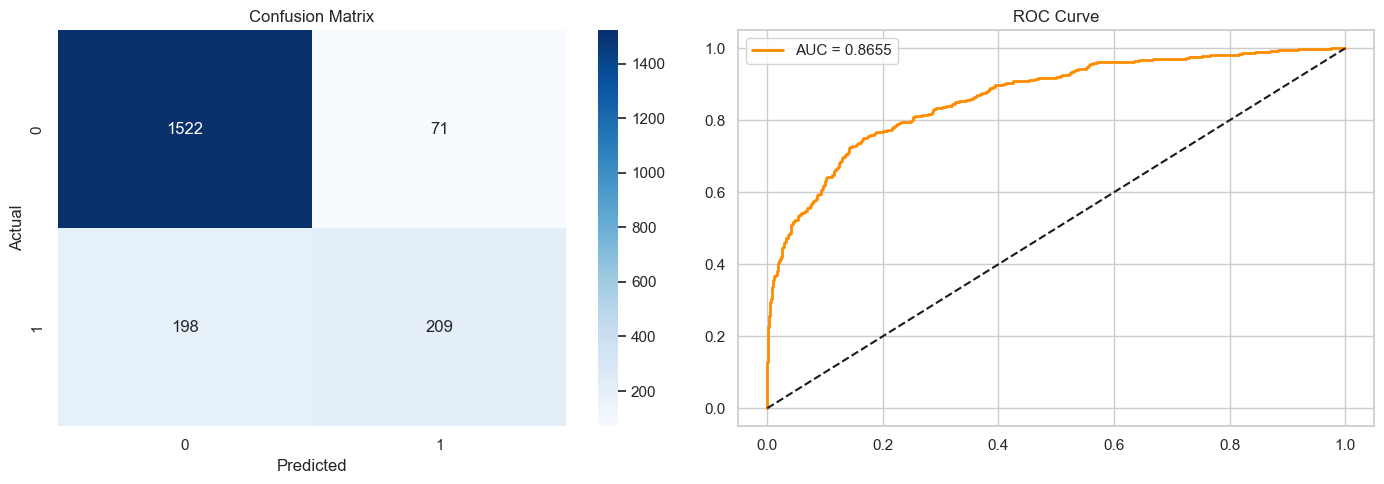

Model saved to churn_pipeline.pkl


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

sns.set(style="whitegrid")

# Shared Feature Engineering Logic Defined outside the class so it can be used by both Training and Prediction phases
def engineer_features(df):
    df = df.copy()
    
    # Adding small epsilon to avoid division by zero
    df['BalanceSalaryRatio'] = df['Balance'] / (df['EstimatedSalary'] + 1e-6)
    df['TenureByAge'] = df['Tenure'] / df['Age']
    df['CreditScoreAgeRatio'] = df['CreditScore'] / df['Age']
    
    # Droping ID columns that offers no predictive signal
    drop_cols = ['RowNumber', 'CustomerId', 'Surname']
    df = df.drop(columns=drop_cols, errors='ignore')
    
    return df

# Professional Churn Predictor Class
class ChurnPredictor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.pipeline = None
        self.X_test = None
        self.y_test = None
        
    def load_and_preprocess(self):
        print("Loading Data...")
        df = pd.read_csv(self.data_path)
        
        # applied Feature Engineering
        print("Engineering Features (Ratios & Cleanup)...")
        df_processed = engineer_features(df)
        
        X = df_processed.drop('Exited', axis=1)
        y = df_processed['Exited']
        
        # Identifying Column Types for Pipeline
        self.numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
        # Splitting Data (Stratify ensures churn rate is preserved in test set)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Data Loaded. Train Shape: {self.X_train.shape}")

    def build_pipeline(self):
        # Data Preprocessing Step
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.categorical_features)
            ])
        
        # We use GradientBoosting as it generally outperforms Random Forest on tabular data
        self.pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, sampling_strategy=0.3)), # Generate synthetic samples (30% ratio)
            ('classifier', GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42))
        ])
        print("Pipeline Built Successfully.")

    def train(self):
        print("Training Model (this may take a moment)...")
        self.pipeline.fit(self.X_train, self.y_train)
        print("Training Complete.")

    def evaluate(self):
        print("\n MODEL PERFORMANCE REPORT")
        
        # Predictions
        y_pred = self.pipeline.predict(self.X_test)
        y_prob = self.pipeline.predict_proba(self.X_test)[:, 1]
        
        # Classification Report
        print(classification_report(self.y_test, y_pred))
        
        # ROC-AUC Score
        auc = roc_auc_score(self.y_test, y_prob)
        print(f"ROC-AUC Score: {auc:.4f}")
        
        # Visualizations
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title('Confusion Matrix')
        axes[0].set_ylabel('Actual')
        axes[0].set_xlabel('Predicted')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        axes[1].plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='darkorange', lw=2)
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title('ROC Curve')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

    def save_model(self, filename='churn_pipeline.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self.pipeline, f)
        print(f"Model saved to {filename}")

# Prediction Helper
def predict_new_customer(customer_dict, model_path='churn_pipeline.pkl'):
    
    # Load Model
    with open(model_path, 'rb') as f:
        loaded_pipeline = pickle.load(f)
        
    # Converting to DataFrame
    df_new = pd.DataFrame([customer_dict])
    
    # Apply the SAME feature engineering as training
    df_processed = engineer_features(df_new)
    prob = loaded_pipeline.predict_proba(df_processed)[0][1]
    
    # Decision Logic (Threshold 0.4 for higher sensitivity)
    if prob > 0.7:
        risk = "CRITICAL (Immediate Action Required)"
    elif prob > 0.4:
        risk = "HIGH (Send Retention Offer)"
    else:
        risk = "LOW (Safe)"
        
    return prob, risk


DATASET_PATH = 'Dataset/Churn_Modelling.csv' 

system = ChurnPredictor(DATASET_PATH)
system.load_and_preprocess()
system.build_pipeline()
system.train()

system.evaluate()

system.save_model()